In [1]:
import os
import intake
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client


from methods import (t_prime_calculation, 
                         dask_data_to_xarray,
                         area_calculation_real_area,
                         dists_of_lat_eff,
                         temp_ref)


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [8]:
cluster = SLURMCluster(nanny=False)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 00:30:00
#SBATCH --qos=covid-19
#SBATCH --account=covid-19
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:43182 --nthreads 4 --memory-limit 20.00GB --name name --no-nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 48844 instead
  http_address["port"], self.http_server.port


In [9]:
client = Client(cluster)

In [11]:
cluster.scale(40)

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45826")
client

Client Scheduler: tcp://127.0.0.1:45826 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 60.13 GB


In [3]:
client.upload_file('methods.py')

from methods import (t_prime_calculation, 
                         dask_data_to_xarray,
                         area_calculation_real_area,
                         dists_of_lat_eff,
                         temp_ref)



### Download CIMP6 Model Data

In [3]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,15
institution_id,33
source_id,73
experiment_id,103
member_id,141
table_id,29
variable_id,369
grid_label,10
zstore,269423
dcpp_init_year,60


In [4]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


In [5]:
cat = col.search(experiment_id='ssp585', 
          institution_id = "NCAR",
           source_id = "CESM2-WACCM",
            variable_id = 'tas'
          )

In [6]:
cat.keys()

['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn',
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn']

In [8]:
def drop_time_bounds(ds):
    if 'time_bounds' in ds.coords:
        ds = ds.drop('time_bounds')
    elif 'time_bnds' in ds.coords:
        ds = ds.drop('time_bnds')
    return ds


dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, 
                 "decode_times": True
                }
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [9]:
dset_dict

{'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn': <xarray.Dataset>
 Dimensions:    (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 31391)
 Coordinates:
     time_bnds  (time, nbnd) object dask.array<chunksize=(15696, 2), meta=np.ndarray>
     lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
     lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time       (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
   * member_id  (member_id) <U8 'r1i1p1f1'
 Dimensions without coordinates: nbnd
 Data variables:
     tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 398, 192, 288), meta=np.ndarray>
 Attributes:
     Conventions:             CF-1.7 CMIP-6.2
     activity_id:             ScenarioMIP
     branch_method:           standard
     branch_tim

In [10]:
def preprocesser(ds,
                 freq='12H',
                 winter=True,
                 start_date=None,
                 end_date=None):

    """
    Pre-processing file mapped to all files pasaed to the reader-n-cutter
    function.

    This pre-processing function mainly takes care of the dates within the
    files. Ideally, the user will pass a date boundary so files can be
    subsetted in the time dimension (index).
    """

    ds = ds.sortby('time')

    if winter is True:
        
        try:
            years_in_array = pd.DatetimeIndex(ds.time.values).year.unique().sort_values()

        except TypeError:
            min_date, max_date = ds.time.values.min(), ds.time.values.max()
        
        if len(years_in_array) == 2:
            date_array = pd.date_range(f'{years_in_array[0]}-12-01',
                                      f'{years_in_array[1]}-03-01',
                                      freq=freq)
            ds_subset = ds.where(
                ds.time.isin(date_array), drop=True)

        else:
            raise ValueError(f'{years_in_array} are more than the desired years')

    else:
        date_array =  pd.daate_range(start_date, end_date, freq=freq)

        ds_subset = ds.where(
                ds.time.isin(date_array), drop=True)

    return ds_subset

In [11]:
entry = cat[list(dset_dict.keys())[0]]
ds = entry(zarr_kwargs={'consolidated': True, 'decode_times': True}).to_dask()
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 31391)
Coordinates:
    time_bnds  (time, nbnd) object dask.array<chunksize=(15696, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 398, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    735110.0
    branch_time_in_parent:   735110.0
    case_id:                 43
    cesm_casename:           b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM...
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-02-08T20:55:56Z
    data_specs_version:      01.00.29
    experiment:              update of RCP8.5 based on SSP5
    experiment_id:           ssp585
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2-...
    grid:                    native 0.9x1.25 finite volume grid (192x288 latx...
    grid_label:              gn
    initialization_index:    1
    institution:             National Center for Atmospheric Research, Climat...
    institution_id:          NCAR
    license:                 CMIP6 model data produced by <The National Cente...
    mip_era:                 CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        CESM2-WACCM
    parent_time_units:       days since 0001-01-01 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    source_id:               CESM2-WACCM
    source_type:             AOGCM BGC CHEM AER
    status:                  2020-02-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    tracking_id:             hdl:21.14100/9221ca13-9cb6-4beb-840d-4f51ca7ec9a...
    variable_id:             tas
    variant_info:            CMIP6 CESM2 future scenario SSP5-8.5 between 201...
    variant_label:           r1i1p1f1
    intake_esm_varname:      tas
    intake_esm_dataset_key:  ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn

In [12]:
ds_cut = ds.sel(lat=slice(20, 90))
ds_cut_time = ds_cut.where(
     ds_cut.time.dt.season == 'DJF' , drop=True
)


In [13]:
ds_cut_time

<xarray.Dataset>
Dimensions:    (lat: 75, lon: 288, member_id: 1, nbnd: 2, time: 7741)
Coordinates:
    time_bnds  (time, nbnd) object dask.array<chunksize=(3871, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * lat        (lat) float64 20.26 21.2 22.15 23.09 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 123, 75, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    735110.0
    branch_time_in_parent:   735110.0
    case_id:                 43
    cesm_casename:           b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM...
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-02-08T20:55:56Z
    data_specs_version:      01.00.29
    experiment:              update of RCP8.5 based on SSP5
    experiment_id:           ssp585
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2-...
    grid:                    native 0.9x1.25 finite volume grid (192x288 latx...
    grid_label:              gn
    initialization_index:    1
    institution:             National Center for Atmospheric Research, Climat...
    institution_id:          NCAR
    license:                 CMIP6 model data produced by <The National Cente...
    mip_era:                 CMIP6
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        CESM2-WACCM
    parent_time_units:       days since 0001-01-01 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    source:                  CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite ...
    source_id:               CESM2-WACCM
    source_type:             AOGCM BGC CHEM AER
    status:                  2020-02-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    tracking_id:             hdl:21.14100/9221ca13-9cb6-4beb-840d-4f51ca7ec9a...
    variable_id:             tas
    variant_info:            CMIP6 CESM2 future scenario SSP5-8.5 between 201...
    variant_label:           r1i1p1f1
    intake_esm_varname:      tas
    intake_esm_dataset_key:  ScenarioMIP.NCAR.CESM2-WACCM.ssp585.day.gn

In [ ]:
ds = ds_cut_time.compute()

In [ ]:
import cartopy.crs as ccrs
fig = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Orthographic(20,90))
ds.isel(member_id=0, time=-1).tas.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();

In [16]:
ds_cut_time.to_netcdf('/project2/geos39650/jet_stream/data/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
             mode = 'w', format = 'NETCDF4' )

### Using saved subset model

In [286]:
test_era = xr.open_dataset('/project2/geos39650/jet_stream/data/df_lat_20_1D.nc')
test_era_day =  test_era.sel(time=slice('2018-01-01', '2019-03-01'))

In [287]:
test_era_day

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 59)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-02-28
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
Data variables:
    t2m        (time, latitude, longitude) float32 ...

In [210]:
ds_cut_time = xr.open_dataset('/project2/geos39650/jet_stream/data/ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day.nc4',
                              chunks={'time': 1})

ds_cut_time_member = ds_cut_time.isel(member_id=0, nbnd=0)
ds_cut_time_member

,Array,Chunk
Bytes,61.93 kB,8 B
Shape,"(7741,)","(1,)"
Count,15483 Tasks,7741 Chunks
Type,object,numpy.ndarray


In [211]:
datetime_index = ds_cut_time_member.indexes['time'].to_datetimeindex()
ds_cut_time_member['time'] = datetime_index

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [292]:
t_df_filtered = test_era_day.to_dask_dataframe(dim_order=['time', 'latitude', 'longitude'])

In [243]:
t_df = ds_cut_time_member.to_dask_dataframe(dim_order=['time', 'lat', 'lon'])

t_df_renamed = t_df.rename(columns={
    'lat': 'latitude',
    'lon': 'longitude',
    'tas': 't2m'
})
t_df_filtered = t_df_renamed[['time', 'latitude', 'longitude', 't2m']]



In [297]:
areas = area_calculation_real_area(t_df_filtered,
                                   cut_interval=2,
                                   grid_lat=0.25,
                                   grid_lon=0.25,
                                   resample_time=False)
                      

In [298]:
areas_no_index = areas.reset_index(drop=False)
areas_no_index

,temp_bracket,time,area_grid
0,"(213.408, 215.408]",2018-01-01,0.0
1,"(213.408, 215.408]",2018-01-02,0.0
2,"(213.408, 215.408]",2018-01-03,0.0
3,"(213.408, 215.408]",2018-01-04,0.0
4,"(213.408, 215.408]",2018-01-05,0.0
...,...,...,...
2650,"(301.408, 303.408]",2018-02-24,167053632.0
2651,"(301.408, 303.408]",2018-02-25,167094032.0
2652,"(301.408, 303.408]",2018-02-26,167096928.0
2653,"(301.408, 303.408]",2018-02-27,167089040.0


In [299]:
areas_no_index_test = areas_no_index[areas_no_index['time'] == '2018-01-01']
areas_no_index_test

,temp_bracket,time,area_grid
0,"(213.408, 215.408]",2018-01-01,0.000000e+00
59,"(215.408, 217.408]",2018-01-01,0.000000e+00
118,"(217.408, 219.408]",2018-01-01,0.000000e+00
177,"(219.408, 221.408]",2018-01-01,0.000000e+00
236,"(221.408, 223.408]",2018-01-01,0.000000e+00
295,"(223.408, 225.408]",2018-01-01,9.050120e+03
354,"(225.408, 227.408]",2018-01-01,8.428089e+04
413,"(227.408, 229.408]",2018-01-01,1.819924e+05
472,"(229.408, 231.408]",2018-01-01,3.410296e+05
531,"(231.408, 233.408]",2018-01-01,5.428188e+05


In [300]:
areas_no_index_test['cdf_eff_lat_mapping'] = areas_no_index_test.groupby('time').\
area_grid.apply(lambda x: dists_of_lat_eff(x))

areas_no_index_test['temp_bracket'] = areas_no_index_test.temp_bracket.apply(lambda x: x.left.astype(float)).astype(float)
areas_no_index_test['eff_lat_deg'] = np.rad2deg(areas_no_index_test.cdf_eff_lat_mapping)
areas_no_index_test

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,temp_bracket,time,area_grid,cdf_eff_lat_mapping,eff_lat_deg
0,213.408,2018-01-01,0.000000e+00,1.570796,90.000000
59,215.408,2018-01-01,0.000000e+00,1.570796,90.000000
118,217.408,2018-01-01,0.000000e+00,1.570796,90.000000
177,219.408,2018-01-01,0.000000e+00,1.570796,90.000000
236,221.408,2018-01-01,0.000000e+00,1.570796,90.000000
295,223.408,2018-01-01,9.050120e+03,1.562367,89.517052
354,225.408,2018-01-01,8.428089e+04,1.545071,88.526070
413,227.408,2018-01-01,1.819924e+05,1.532994,87.834084
472,229.408,2018-01-01,3.410296e+05,1.519048,87.035019
531,231.408,2018-01-01,5.428188e+05,1.505504,86.259010


In [301]:
import dask

t_max, t_min = dask.compute(t_df_filtered['t2m'].max(), t_df_filtered['t2m'].min())                                                                                              
range_cuts = np.arange(t_min, t_max, 2)                                                                                                                                                    
t_df_filtered['temp_bracket'] = t_df_filtered['t2m'].map_partitions(                                                                                                                       
    pd.cut, range_cuts                                                                                                                                                           
)

t_df_filtered_test = t_df_filtered[t_df_filtered.time == '2018-01-01']                                                                                                                          
t_df_filtered_test['temp_bracket'] = t_df_filtered_test.temp_bracket.apply(lambda x: x.left.astype(float))

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/dask/dataframe/core.py:3095: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


In [302]:
t_df_filtered_test = t_df_filtered_test.compute()

In [351]:
ddf_merge = t_df_filtered_test.merge(areas_no_index_test,
                          on=['time', 'temp_bracket'], how='left')


t_ref =  np.interp(ddf_merge.latitude,
                   np.flip(ddf_merge['eff_lat_deg']),
                   np.flip(ddf_merge['temp_bracket']),
                   period=70
                  )

In [352]:
ddf_merge.sort_values(['latitude'])

,time,latitude,longitude,t2m,area_grid_x,temp_bracket,t_ref,t_prime,area_grid_y,cdf_eff_lat_mapping,eff_lat_deg
403199,2018-01-01,20.25,359.75,294.632874,724.202454,293.408,274.255490,20.377383,156399712.0,0.396362,22.709887
402234,2018-01-01,20.25,118.50,295.663147,724.202454,295.408,274.255490,21.407657,164261120.0,0.363134,20.806059
402235,2018-01-01,20.25,118.75,295.661530,724.202454,295.408,274.255490,21.406039,164261120.0,0.363134,20.806059
402236,2018-01-01,20.25,119.00,295.617371,724.202454,295.408,274.255490,21.361880,164261120.0,0.363134,20.806059
402237,2018-01-01,20.25,119.25,295.618195,724.202454,295.408,274.255490,21.362704,164261120.0,0.363134,20.806059
...,...,...,...,...,...,...,...,...,...,...,...
963,2018-01-01,90.00,240.75,251.755646,-0.000034,251.408,295.204262,-43.448616,32384498.0,1.061068,60.794731
964,2018-01-01,90.00,241.00,251.755646,-0.000034,251.408,295.204262,-43.448616,32384498.0,1.061068,60.794731
965,2018-01-01,90.00,241.25,251.755646,-0.000034,251.408,295.204262,-43.448616,32384498.0,1.061068,60.794731
967,2018-01-01,90.00,241.75,251.755646,-0.000034,251.408,295.204262,-43.448616,32384498.0,1.061068,60.794731


In [353]:
t_df_filtered_test['t_ref']= t_ref
t_df_filtered_test['t_prime'] = t_df_filtered_test.t2m - t_df_filtered_test.t_ref

In [354]:
from dask import dataframe as dd 
sd = dd.from_pandas(t_df_filtered_test, npartitions=3)

In [355]:
t_ref_test = dask_data_to_xarray(df=sd,
                         dims=['time', 'latitude', 'longitude'],
                         target_variable='t_prime')

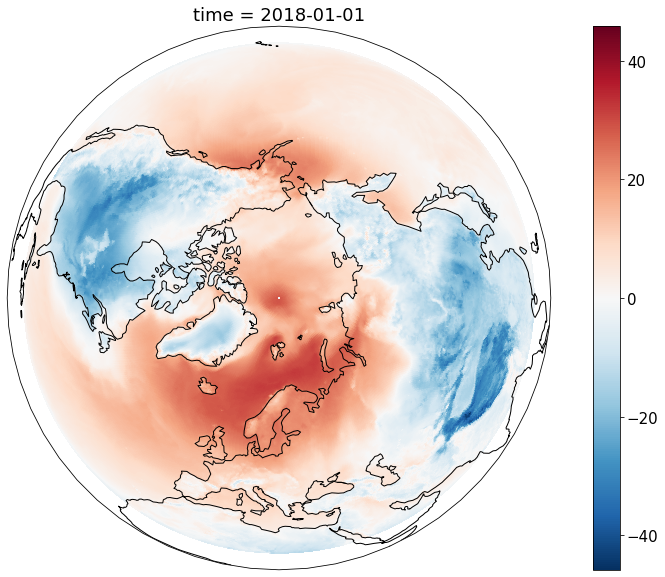

In [356]:
import cartopy.crs as ccrs
fig = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Orthographic(20,90))
t_ref_test.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();

In [284]:
t_prime_old = xr.open_dataset('/project2/geos39650/jet_stream/data/model_output/tprime/t_prime_test_blobs_no_resample_2015-12-01_2020-03-01.nc4')
t_prime_old = t_prime_old.rename({'__xarray_dataarray_variable__': 't_prime'})

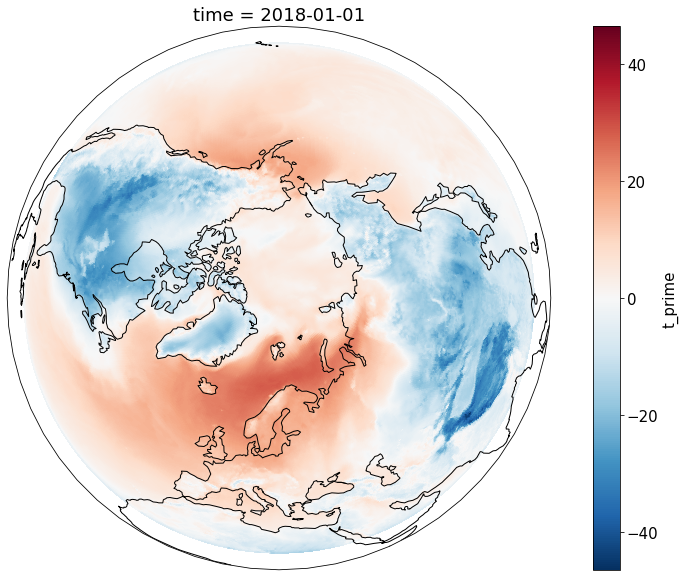

In [285]:
import cartopy.crs as ccrs
fig = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Orthographic(20,90))
t_prime_old.sel(time='2018-01-01').t_prime.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();

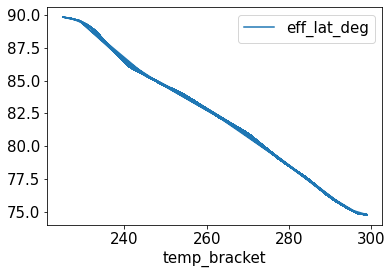

In [75]:

ddf_merge.plot(x='temp_bracket', y='eff_lat_deg')

In [17]:
test_ultimate = t_prime_calculation(t_df_filtered,
                                    resample_time=False,
                                    grouping_time_interval='1w',
                                    build_buckets=True,
                                    cut_interval=2
                               )

KeyboardInterrupt: 

In [7]:
t_ref_test = dask_data_to_xarray(df=test_ultimate,
                         dims=['time', 'latitude', 'longitude'],
                         target_variable='t_prime')



In [8]:

t_ref_test.to_netcdf(f'/project2/geos39650/jet_stream/data/t_prime_cesm_pred_data.nc4')



In [9]:
t_ref_test

<xarray.DataArray (time: 7741, latitude: 75, longitude: 288)>
array([[[ 49.57226514,  49.41671704,  47.50964307, ...,  47.58819531,
          47.44393872,  48.54534863],
        [ 47.59716748,  47.80996655,  47.59100293, ...,  47.62527417,
          47.24334668,  47.08224438],
        [ 46.30718945,  47.36318921,  47.66900586, ...,  47.12524365,
          45.91287183,  46.10974072],
        ...,
        [-36.44189502, -36.60836841, -36.77496387, ..., -36.02142383,
         -36.15702869, -36.29219104],
        [-36.17303516, -36.2382207 , -36.30865527, ..., -35.98306323,
         -36.04150439, -36.10688831],
        [-36.95042468, -36.94517566, -36.94036914, ..., -36.96958972,
         -36.96257068, -36.9561925 ]],

       [[ 26.22717236,  24.46807812,  22.88943433, ...,  25.13055371,
          25.23339795,  26.36373853],
        [ 25.06442212,  24.3517146 ,  22.86120557, ...,  25.00897168,
          24.81140088,  24.8965144 ],
        [ 24.04055737,  24.26919507,  23.6161189 , ...,  25.02828931,
          23.89874219,  23.90451001],
        ...,
        [-50.45155383, -50.41871692, -50.38855029, ..., -50.50173999,
         -50.48835803, -50.47624255],
        [-50.86792041, -50.89817859, -50.92767383, ..., -50.7780614 ,
         -50.80578662, -50.836823  ],
        [-50.38763477, -50.39028979, -50.39271594, ..., -50.37794543,
         -50.38150073, -50.38470508]],

       [[ 31.65191602,  30.93151807,  29.91104077, ...,  30.44085645,
          30.50472974,  31.57870435],
        [ 30.48910474,  30.45199536,  29.76538037, ...,  30.4018855 ,
          30.087646  ,  30.21572827],
        [ 29.92626904,  30.08044385,  29.59872388, ...,  30.76727246,
          29.61956738,  29.58969067],
        ...,
        [-54.66789294, -54.65808154, -54.64538623, ..., -54.6784978 ,
         -54.67926074, -54.67627002],
        [-53.17332507, -53.18637134, -53.19836475, ..., -53.11517383,
         -53.13758899, -53.15707446],
        [-51.77786304, -51.78079272, -51.78346301, ..., -51.76707507,
         -51.77104236, -51.77462817]],

       ...,

       [[ 28.15594434,  27.7876582 ,  26.60150098, ...,  27.05462598,
          27.01296948,  28.25323437],
        [ 27.1933894 ,  26.93597363,  26.20642041, ...,  27.19006299,
          26.99404858,  27.14770459],
        [ 26.83685254,  26.82748364,  26.06191968, ...,  27.26089429,
          26.23419141,  26.31738232],
        ...,
        [-24.45666553, -24.4368291 , -24.41915942, ..., -24.51632739,
         -24.49624683, -24.47757007],
        [-24.70422412, -24.69952441, -24.69479419, ..., -24.72195483,
         -24.71551563, -24.7095647 ],
        [-24.95196582, -24.95120288, -24.95050098, ..., -24.95474292,
         -24.95370532, -24.95278979]],

       [[ 53.51513623,  53.70028638,  53.7859187 , ...,  51.97259473,
          52.05279492,  53.10488843],
        [ 51.96926831,  52.15682935,  52.37936353, ...,  51.64596509,
          51.74862622,  51.68527173],
        [ 51.11950635,  51.48715161,  51.56671094, ...,  51.59518384,
          50.81210278,  50.86624097],
        ...,
        [-23.68228198, -23.66159106, -23.64331104, ..., -23.74334766,
         -23.72268726, -23.70358325],
        [-24.04821826, -24.03973438, -24.03115894, ..., -24.07879688,
         -24.06771899, -24.05752612],
        [-24.3269353 , -24.32598926, -24.32513477, ..., -24.33032275,
         -24.32907153, -24.32794238]],

       [[ 39.71618604,  39.64401196,  39.22451733, ...,  38.99414014,
          38.9327998 ,  39.83071851],
        [ 38.31079053,  38.35742139,  38.09915112, ...,  39.23141431,
          38.75973462,  38.51321362],
        [ 37.77227734,  37.86633252,  37.75707959, ...,  39.58444165,
          38.14553784,  37.69399976],
        ...,
        [-23.90759326, -23.90255786, -23.89721729, ..., -23.91861011,
         -23.91540576, -23.91189624],
        [-23.83679248, -23.83636523, -23.83593799, ..., -23.8373418 ,
         -23.83755542, -23.83721973],
        [-23.86630298, -23.86611987, -23.86593677, ..., -

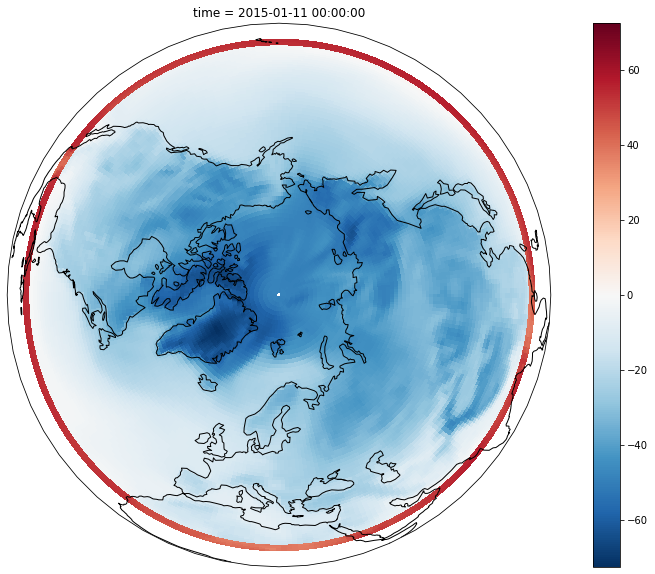

In [13]:
import cartopy.crs as ccrs
fig = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Orthographic(20,90))
t_ref_test.isel(time=10).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();